**Deberá crear un modelo que pueda pronosticar la demanda de 2022-05, 06 y 07, de Cementos Argos. El código de esto deberá hacerlo en un Jupyter notebook, el output debe ser un archivo con todos los datos incluyendo los pronósticos, además de un gráfico donde se pueda apreciar cual fue su data de entrenamiento, de validación y pronóstico, dentro de este gráfico se debe apreciar las métricas con las que decidió que su modelo estaría dando un resultado confiable (Puede usar las que considere).**

### Instalación e importación de librerías

In [ ]:
!pip install plotly statsmodels scikit-learn nbformat>=4.2.0 notebook ipywidgets

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### 1. Exploración de datos

In [107]:
df=pd.read_csv("dataset_demand_acumulate.csv")
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   year_month  64 non-null     datetime64[ns]
 1   Demand      64 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 KB


In [108]:
df.head()

,year_month,Demand
0,2017-01-01,1211.009490
1,2017-02-01,1660.584649
2,2017-03-01,3182.587014
3,2017-04-01,3506.515270
4,2017-05-01,4554.082280


In [109]:
# Visualización de la data

fig = px.line(df, x='year_month', y='Demand')

fig.update_layout(
    title={
        'text': 'Serie tiempo Demanda Cemento Argos',
        'x': 0.5})

fig.show()

### 2. Entrenamiento

1. Tenemos el caso del comportamiento de la demanda en el tiempo donde se observa estacionalidades muy marcadas con picos en los meses de Diciembre y valles en Enero.
2. También se observa una caída en la demanda año tras año, exceptuando el 2022 el cual tiene una recuperación vs el 2021. Esto representa un cambio en las condiciones de mercado tal vez por un nuevo cliente, comportamiento del mercado en general o una situación puntual. 
3. Se empleará SARIMAX con ajuste de hiperparámetros para obtener el modelo más óptimo con la agregación de una variable exogena que le permita al modelo identificar que a partir del 2021 la tendencia decreciente cambia
4. Finalmente, el conjunto para el test se toma con las últimas fechas cuyo conjunto tiene una longitud del 15% vs la proporción de toda la data. No se toma un porcentaje más alto con el propósito de que el modelo en el entrenamiento identifique la tendencia alcista del 2021 y lo tenga en cuenta para la predicción futura

In [110]:
df_S=df.copy()

# Verificación estacionalidad de los datos

result = adfuller(df_S['Demand'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] > 0.05:
    print("La serie no es estacionaria.")
else:
    print("La serie es estacionaria.")

#Aplicación de logaritmo natural a los datos para proporcionar estabilidad en entrenamiento
df_S['Demand'] = np.log(df_S['Demand']) 

df_S.set_index('year_month', inplace=True)

# Especificación frecuencia mensual
df_S = df_S.asfreq('MS') 

# Se agrega variable exogena desde 2021, por que cambia la tendencia decreciente año a año
df_S['Exg'] = (df_S.index >= '2021-01-01').astype(int) 

df_S.head(100)


ADF Statistic: -4.441016187942845
p-value: 0.00025096210164984075
La serie es estacionaria.


,Demand,Exg
year_month,,
2017-01-01,7.099210,0
2017-02-01,7.414925,0
2017-03-01,8.065450,0
2017-04-01,8.162378,0
2017-05-01,8.423779,0
...,...,...
2021-12-01,8.008469,1
2022-01-01,5.381348,1
2022-02-01,5.805324,1


In [ ]:
# Separar datos en entrenamiento y testeo. Para el test se toma el 15% de la data, con el propósito que el entrenamiento tome parte del comportamiento creciente de 2021
train_size = int(len(df_S) * 0.85)
train = df_S.iloc[:train_size]
test = df_S.iloc[train_size:]

In [112]:
# Definir rangos de hiperparámetros para SARIMA
p = q= range(0, 5) # Autorregresivo,  media móvil
d = range(0, 3)  # diferenciación
P = D = Q = range(0, 3)  # Estacionalidad
s = [12]  # Periodo estacional (mensual)

# Generar combinaciones de hiperparámetros
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))

In [113]:
best_aic = np.inf
best_params = None
best_model = None

# Iterar por todas las combinaciones de hiperparámetros
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            
            #model = SARIMAX(train['Demand'], order=param, seasonal_order=seasonal_param, enforce_stationarity=False, enforce_invertibility=False, exog=train['Exg'])
            model = SARIMAX(train['Demand'], order=param, seasonal_order=seasonal_param, exog=train['Exg'])
            
            results = model.fit(disp=False, maxiter=200)
            
            # Seleccionar modelo con el menor AIC
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, seasonal_param)
                best_model = results
        except:
            continue

print(f"Mejor modelo SARIMA: {best_params} con AIC={best_aic}")


Mejor modelo SARIMA: ((1, 1, 1), (2, 1, 0, 12)) con AIC=-18.05366674843754


In [114]:

print(best_model.mle_retvals)  


{'fopt': np.float64(-0.2782746921151624), 'gopt': array([-3.57488283e-04,  2.55058080e-04,  3.99808020e-05, -4.98613595e-04,
       -1.63159197e-04,  3.39777573e-04]), 'fcalls': 511, 'warnflag': 0, 'converged': True, 'iterations': 54}


### 3. Test con el mejor modelo

In [115]:
# Se define la función MAPE para hacer seguimiento de los resultados, pues es fácil de interpretar y es muy usada en comportamientos de demanda

def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

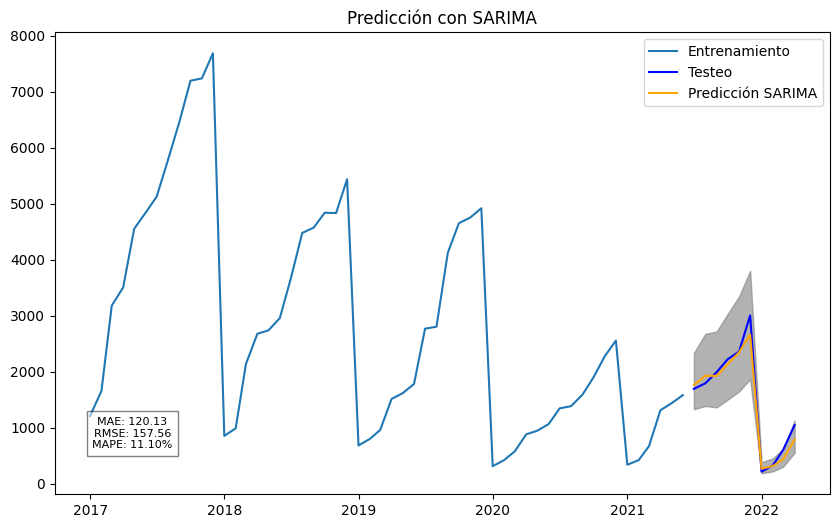

In [116]:
# Predicciones
sarima_forecast = best_model.get_forecast(steps=len(test), exog=test["Exg"])
sarima_pred = sarima_forecast.predicted_mean
sarima_ci = sarima_forecast.conf_int()

# Calcular métricas
mae_sarima = mean_absolute_error(np.exp(test['Demand']), np.exp(sarima_pred))
rmse_sarima = np.sqrt(mean_squared_error(np.exp(test['Demand']), np.exp(sarima_pred)))
mape_sarima= MAPE(np.exp(test['Demand']), np.exp(sarima_pred))

error_text = f'MAE: {mae_sarima:.2f}\nRMSE: {rmse_sarima:.2f}\nMAPE: {mape_sarima:.2f}%'


# Visualización
plt.figure(figsize=(10, 6))
plt.text(0.1, 0.1, error_text, fontsize=8, ha='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.plot(train.index, np.exp(train['Demand']), label='Entrenamiento')
plt.plot(test.index, np.exp(test['Demand']), label='Testeo', color='blue')
plt.plot(test.index, np.exp(sarima_pred), label='Predicción SARIMA', color='orange')
plt.fill_between(test.index, np.exp(sarima_ci.iloc[:, 0]), np.exp(sarima_ci.iloc[:, 1]), color='gray', alpha=0.6)
plt.legend()
plt.title('Predicción con SARIMA')
plt.show()


In [119]:
print(f"Métricas de error para el cojunto test con el modelo de Sarima ajustado\n\nMAE: {mae_sarima:.2f}\nRMSE: {rmse_sarima:.2f}\nMAPE: {mape_sarima:.2f}%")

Métricas de error para el cojunto test con el modelo de Sarima ajustado

MAE: 120.13
RMSE: 157.56
MAPE: 11.10%


### 4. Proyección de la demanda de 2022-05, 06 y 07

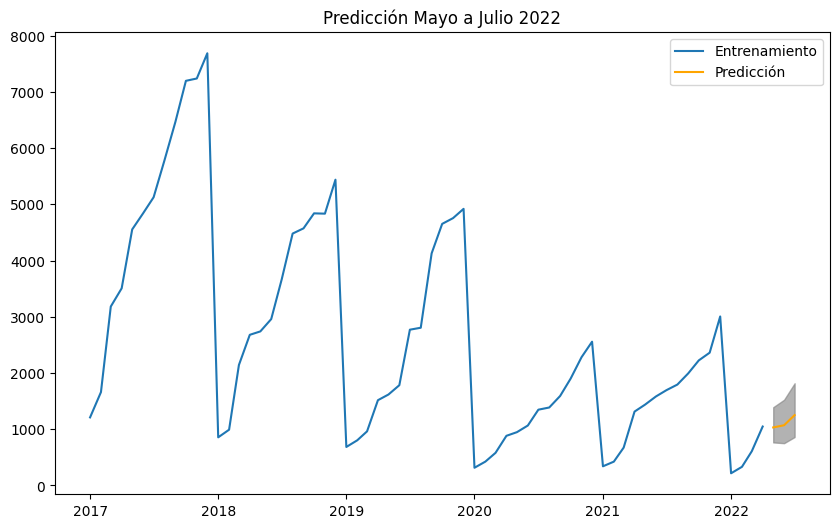

In [120]:
# Entrenamiento con toda la data y los parámetros óptimos

param_opt=best_params[0]
seasonal_opt=best_params[1]
model = SARIMAX(df_S['Demand'], order=param_opt, seasonal_order=seasonal_opt, exog=df_S['Exg'])
results = model.fit(disp=False, maxiter=200)

# Predicciones

sarima_forecast = results.get_forecast(steps=3, exog=[1,1,1])
sarima_pred = np.exp(sarima_forecast.predicted_mean)
sarima_ci = np.exp(sarima_forecast.conf_int())

# Visualización
plt.figure(figsize=(10, 6))
plt.plot(df_S.index, np.exp(df_S['Demand']), label='Entrenamiento')
plt.plot(sarima_pred.index, sarima_pred, label='Predicción', color='orange')
plt.fill_between(sarima_pred.index, sarima_ci.iloc[:, 0], sarima_ci.iloc[:, 1], color='gray', alpha=0.6)
plt.legend()
plt.title('Predicción Mayo a Julio 2022')
plt.show()


### 5. Registro de los datos en el archivo predict

In [126]:
pred=pd.read_csv(r"..\to_predict.csv")
pred.head()

,autoID,SeniorCity,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Charges,Demand,Class
0,9695-TERGH,0,No,No,Yes,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,96.05,NaN,NaN
1,5247-VRIOW,0,No,No,Yes,No,Yes,No,No,Yes,Month-to-month,No,Mailed check,53.45,NaN,NaN
2,5731-DDJUB,0,No,No,Yes,No,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),19.70,NaN,NaN


In [127]:
pred["Demand"]=sarima_pred.values
pred.to_csv(r"..\to_predict.csv", index=False)
pred.head()

,autoID,SeniorCity,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Charges,Demand,Class
0,9695-TERGH,0,No,No,Yes,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,96.05,1032.561675,NaN
1,5247-VRIOW,0,No,No,Yes,No,Yes,No,No,Yes,Month-to-month,No,Mailed check,53.45,1071.400747,NaN
2,5731-DDJUB,0,No,No,Yes,No,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),19.70,1251.794909,NaN
